In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


In [117]:
columns = ['unit', 'cycle', 'op_setting1', 'op_setting2', 'op_setting3'] + [f'sensor{i}' for i in range(1,22)]

data_train = pd.read_csv('CMAPSSData/train_FD001.txt', sep = '\s+', header =None, names = columns)


In [118]:
data_train.head()

,unit,cycle,op_setting1,op_setting2,op_setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [119]:
data_train.shape

(20631, 26)

In [120]:
print("Cycles to fail:",data_train.groupby('unit')['cycle'].count().values)

Cycles to fail: [192 287 179 189 269 188 259 150 201 222 240 170 163 180 207 209 276 195
 158 234 195 202 168 147 230 199 156 165 163 194 234 191 200 195 181 158
 170 194 128 188 216 196 207 192 158 256 214 231 215 198 213 213 195 257
 193 275 137 147 231 172 185 180 174 283 153 202 313 199 362 137 208 213
 213 166 229 210 154 231 199 185 240 214 293 267 188 278 178 213 217 154
 135 341 155 258 283 336 202 156 185 200]


In [121]:
def linear_degradation(total_cycles):
    return np.arange(total_cycles-1, -1, -1)

# Function to generate Piecewise Linear Degradation Model
def piecewise_linear_degradation(total_cycles, early_rul=125):
    return np.append(early_rul * np.ones(shape=(total_cycles - early_rul,)), np.arange(early_rul-1, -1, -1))

# Function to generate Exponential Degradation Model
def exponential_degradation(total_cycles, decay_rate=0.05):
    return np.maximum(0, 192 * np.exp(-decay_rate * np.arange(total_cycles)))

# Function to generate Logistic Growth Degradation Model
def logistic_degradation(total_cycles, max_rul=192, k=0.1, t0=96):
    return max_rul / (1 + np.exp(-k * (np.arange(total_cycles) - t0)))

# Function to generate Polynomial Degradation Model
def polynomial_degradation(total_cycles, degree=3):
    x = np.arange(total_cycles)
    coeffs = np.polyfit(x, np.arange(total_cycles-1, -1, -1), degree)
    return np.polyval(coeffs, x)

# Function to process the target RUL
def process_targets(data_length, early_rul=None):
    """
    Takes data_length (total number of cycles for each engine) and early_rul as input 
    and creates target RUL for both models.
    """
    if early_rul is None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            target_array = np.append(early_rul * np.ones(shape=(early_rul_duration,)), np.arange(early_rul-1, -1, -1))
            return target_array

# Function to generate and plot the degradation model based on user choice
def degradation_model(choice, data_length, early_rul=None):
    """
    Takes the choice (1 to 5 for different degradation models), 
    the data length (total number of cycles), and optionally early_rul for piecewise model.
    """
    if choice == 1:
        rul = linear_degradation(data_length)
        plt.plot(rul, label="Linear Degradation Model")
    elif choice == 2:
        rul = piecewise_linear_degradation(data_length, early_rul)
        plt.plot(rul, label="Piecewise Linear Degradation Model")
    elif choice == 3:
        rul = exponential_degradation(data_length)
        plt.plot(rul, label="Exponential Degradation Model")
    elif choice == 4:
        rul = logistic_degradation(data_length)
        plt.plot(rul, label="Logistic Growth Degradation Model")
    elif choice == 5:
        rul = polynomial_degradation(data_length)
        plt.plot(rul, label="Polynomial Degradation Model")
    else:
        print("Invalid choice! Please enter a number between 1 and 5.")
        return

    # Plot the result
    plt.title(f"RUL Degradation Model (Choice {choice})")
    plt.xlabel("Cycle")
    plt.ylabel("Remaining Useful Life (RUL)")
    plt.legend()
    plt.show()

# Example of calling the function:
# You call the function with the desired choice (e.g., 1 for Linear Degradation, 2 for Piecewise, etc.)
# Specify the data length (total cycles) and optionally early_rul if needed for Piecewise Model.
# degradation_model(1, 259)  # Linear Degradation Model for 259 cycles

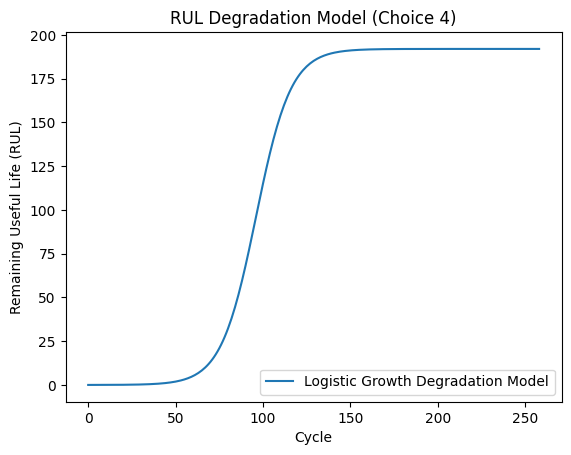

In [122]:
degradation_model(4,259)

In [123]:
data_test = pd.read_csv('CMAPSSData/test_FD001.txt',sep='\s+',header=None,names=columns)
data_test.head()

,unit,cycle,op_setting1,op_setting2,op_setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [124]:
print("Cycles to fail:",data_test.groupby('unit')['cycle'].count().values)

Cycles to fail: [ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [125]:
actual_rul = pd.read_csv('CMAPSSData/RUL_FD001.txt',sep='\s+',header=None)

In [126]:
actual_rul.head()

,0
0,112
1,98
2,69
3,82
4,91


In [127]:
actual_rul[0].values

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20], dtype=int64)

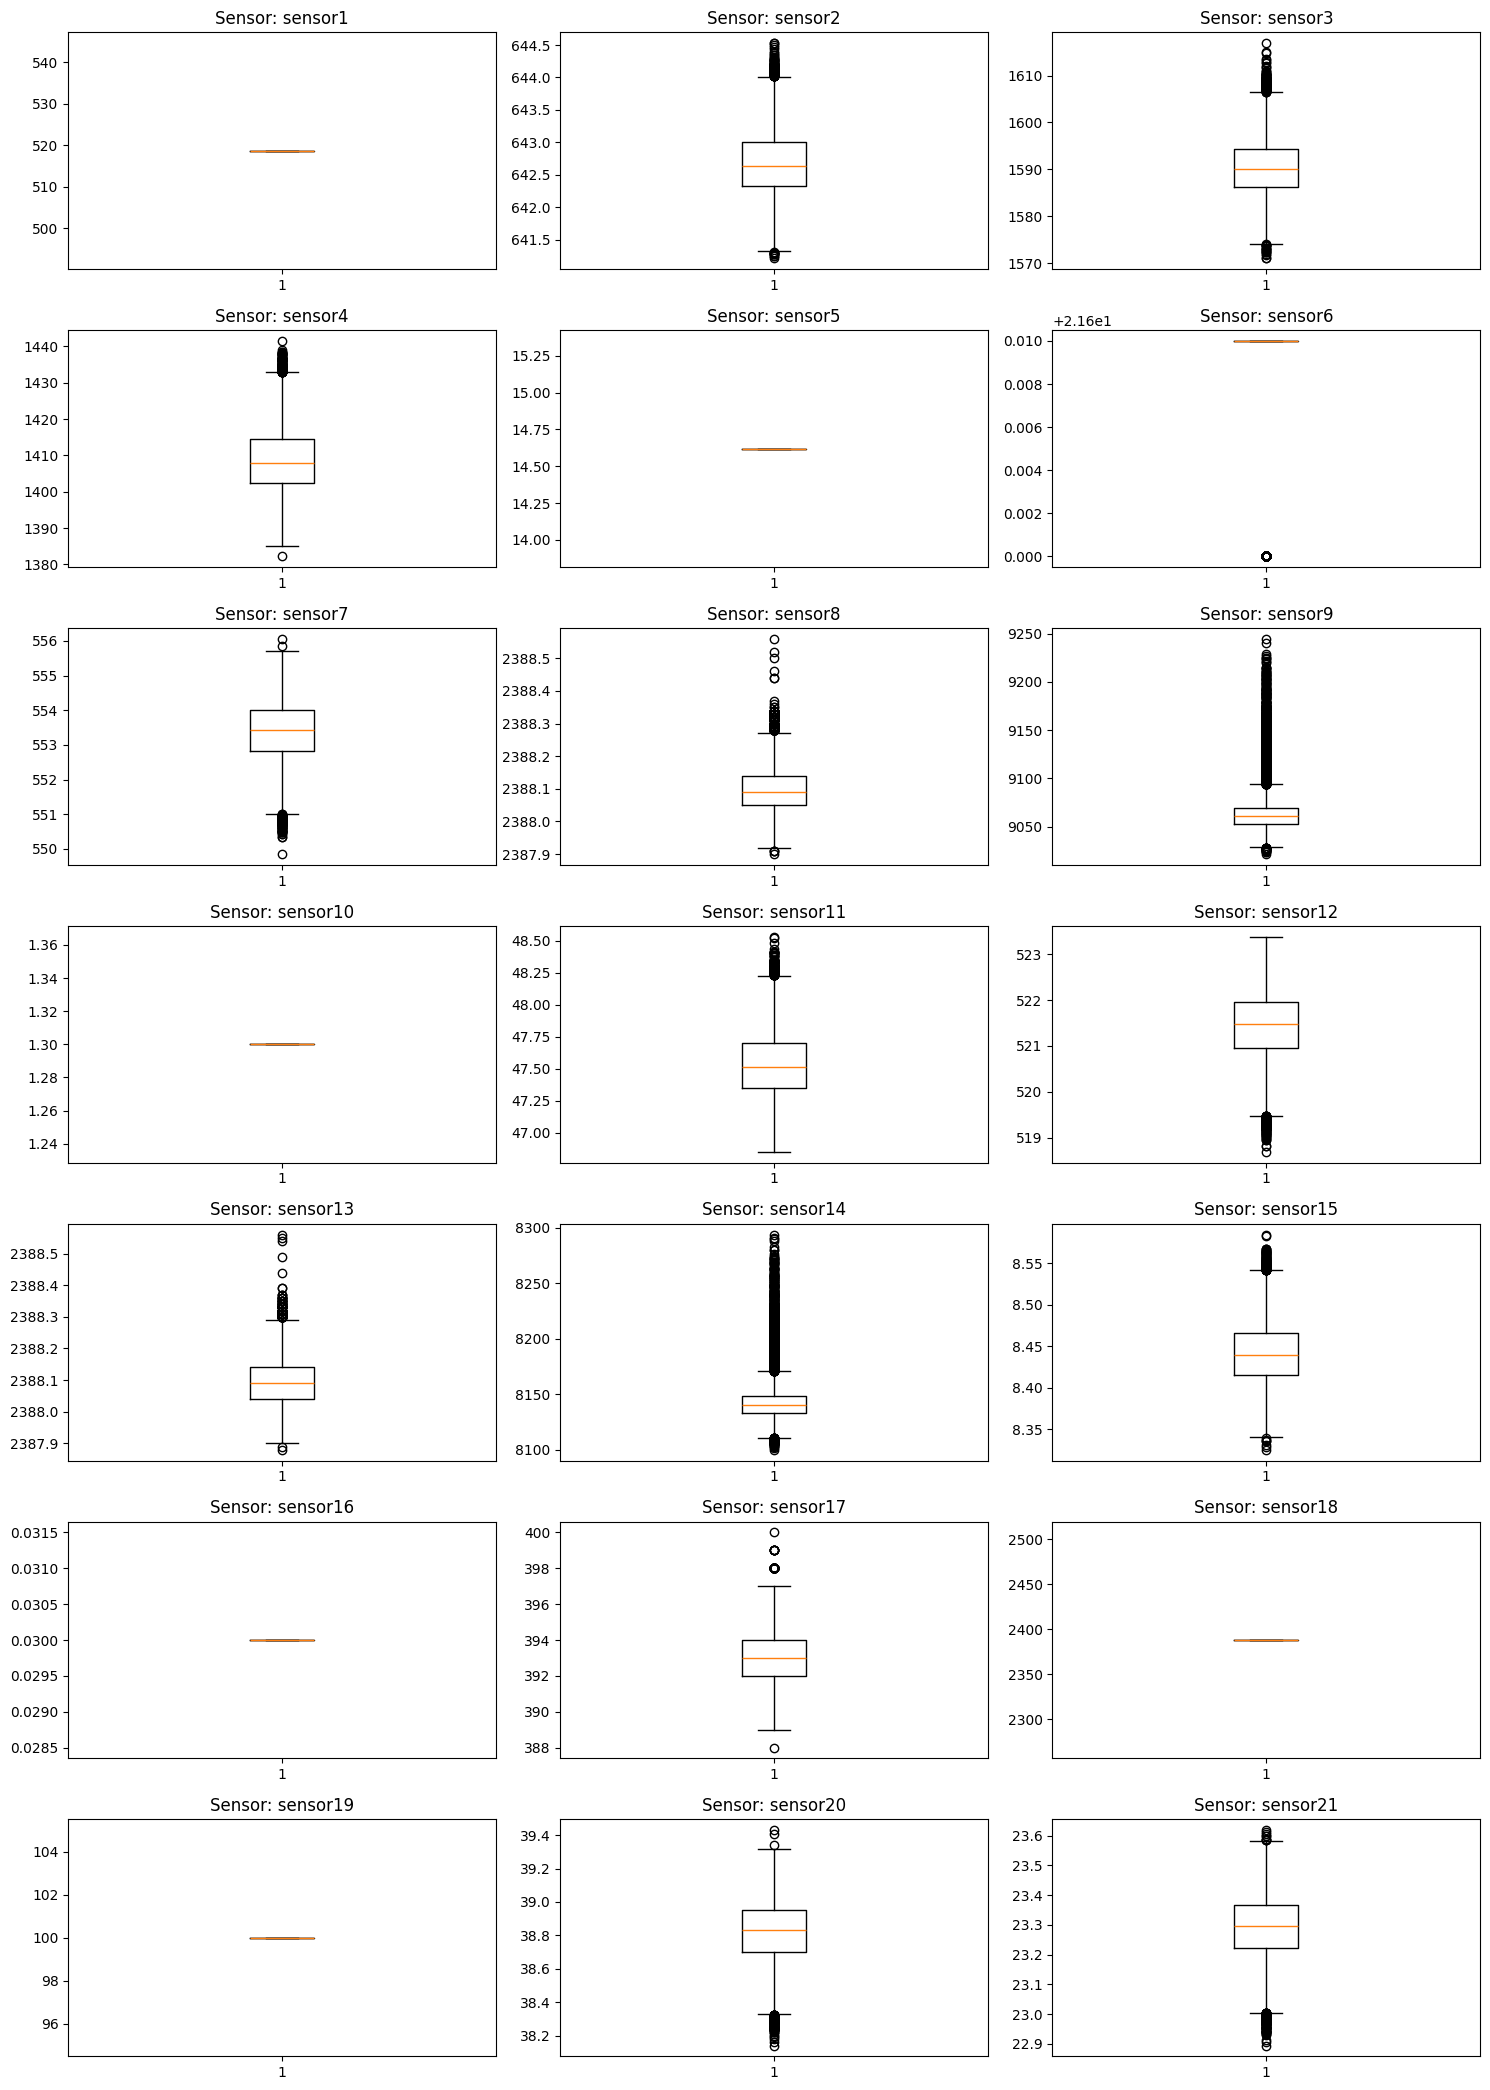

In [128]:
plt.figure(figsize=(15, 21))

for i, col_name in enumerate(columns[5:], start=1):  # column_names[5:] selects from 'sensor1' to 'sensor21'
    temp = data_train[col_name]  # Access the column by name
    plt.subplot(7, 3, i)  # Subplot arrangement (7 rows, 3 columns)
    plt.boxplot(temp)  # Create a boxplot for the sensor data
    plt.title(f"Sensor: {col_name}")  # Set the title as the column name

# Show the plot
plt.tight_layout()  # Ensure no overlap between subplots
plt.show()

In [129]:
working_clms = ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9', 
                   'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17',  'sensor20', 'sensor21']

In [130]:
data_test.head()


,unit,cycle,op_setting1,op_setting2,op_setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [131]:
data_train.head()

,unit,cycle,op_setting1,op_setting2,op_setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


c:\Users\gunik\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gunik\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gunik\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gunik\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

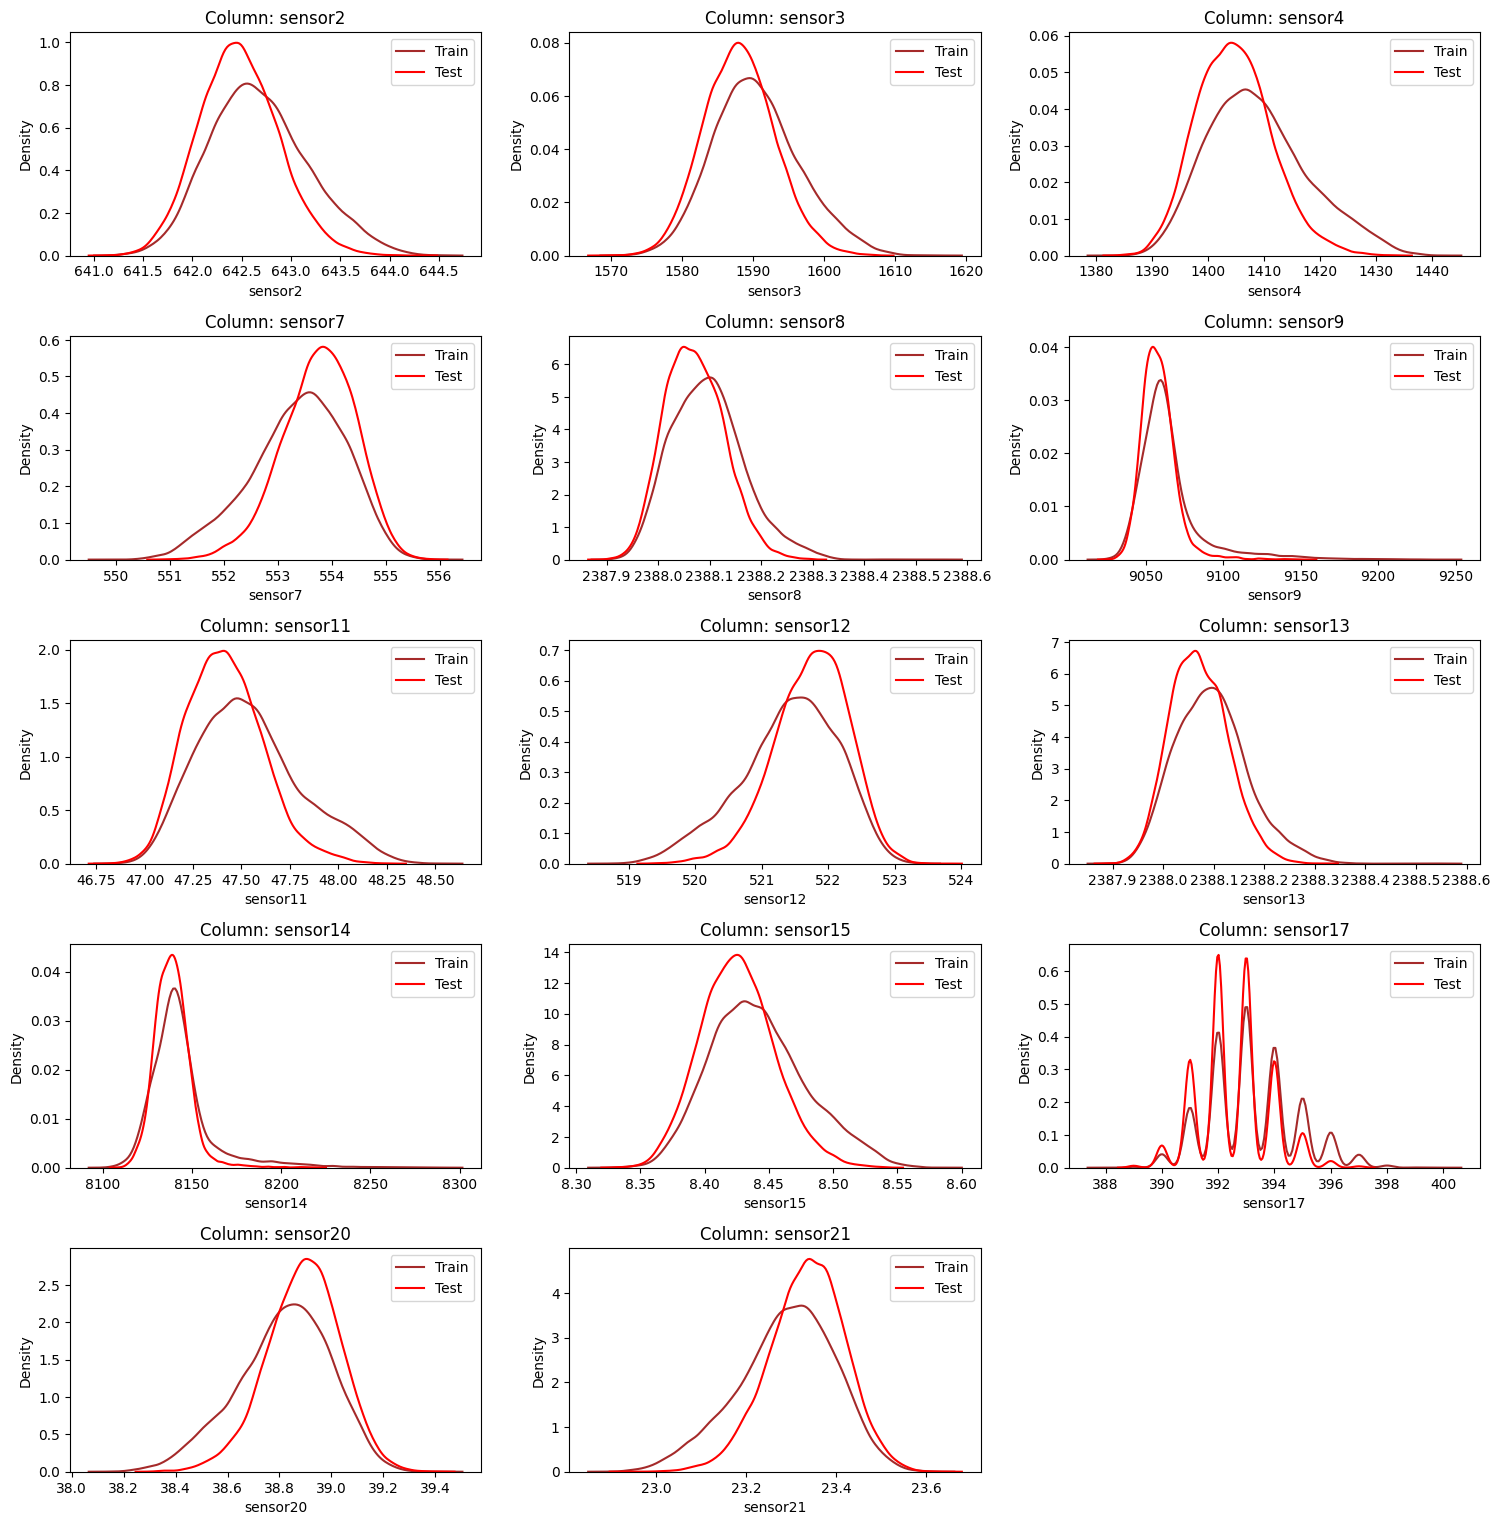

In [132]:
plt.figure(figsize=(15, 21))
for i, col_name in enumerate(working_clms):
    temp_train = data_train[col_name]  # Get data from the training set
    temp_test = data_test[col_name]    # Get data from the test set
    
    plt.subplot(7, 3, i+1)  # Arrange subplots in a grid
    sns.kdeplot(temp_train, legend=False, color="brown", label="Train")
    sns.kdeplot(temp_test, legend=False, color="red", label="Test")
    plt.title(f"Column: {col_name}")  # Use the column name in the title
    plt.legend()

# Show the plot
plt.tight_layout()  # Ensure everything fits without overlap
plt.show()

In [133]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [134]:
data = np.array([[1,2,3,4,5],
                 [6,7,8,9,10],
                 [11,12,13,14,15],
                 [16,17,18,19,20],
                 [21,22,23,24,25],
                 [26,27,28,29,30]])
ruls = np.array([31,32,33,34,35,36])
print("Data:")
print(data)
print()
print("RUL:")
print(ruls)

Data:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]
 [26 27 28 29 30]]

RUL:
[31 32 33 34 35 36]


In [135]:
check_data, check_rul = process_input_data_with_targets(data,target_data = ruls, window_length= 3, shift = 1)
print(check_data)
print()
print(check_rul)

[[[ 1.  2.  3.  4.  5.]
  [ 6.  7.  8.  9. 10.]
  [11. 12. 13. 14. 15.]]

 [[ 6.  7.  8.  9. 10.]
  [11. 12. 13. 14. 15.]
  [16. 17. 18. 19. 20.]]

 [[11. 12. 13. 14. 15.]
  [16. 17. 18. 19. 20.]
  [21. 22. 23. 24. 25.]]

 [[16. 17. 18. 19. 20.]
  [21. 22. 23. 24. 25.]
  [26. 27. 28. 29. 30.]]]

[33. 34. 35. 36.]


In [136]:
def process_data_test(data_test_for_an_engine, window_length, shift, num_test_windows = 1):
    """ 
    This function takes test data for an engine as first input. The next two inputs,
    window_length and shift are same as other functions. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examples we
    want from test data (from last). By default it extracts only the last example.
    
    The function returns last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler helps us do just that.

    Arguments:
        data_test_for_an_engine: (2D array) input test data
        window_length: (scalar) window length of data
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        num_test_windows: (scalar) Number of examples to take from last. (default: 1)

    Returns:
        batched_data_test_for_an_engine: (2D array) Batched test data. Please note that, here we have used the term `batch`
                                         in a different sense than its usual meaning in deep learning.
        extracted_num_test_windows: (scalar) Extracted number of test examples from last. If `num_test_windows` number of
                                    examples can't be extracted from test data, in that case `extracted_num_test_windows`
                                    is less than `num_test_windows`. 
    """
    max_num_test_batches = int(np.floor((len(data_test_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_data_test_for_an_engine = process_input_data_with_targets(data_test_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = max_num_test_batches
        return batched_data_test_for_an_engine, extracted_num_test_windows
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_data_test_for_an_engine = process_input_data_with_targets(data_test_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = num_test_windows
        return batched_data_test_for_an_engine, extracted_num_test_windows

In [137]:
check_data = np.reshape(np.arange(24), newshape = (6,4))
check_data

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23]])

In [138]:
last_examples, num_last_examples = process_data_test(check_data, window_length = 2, shift = 1, num_test_windows= 1)
print(last_examples)
print()
print(num_last_examples)

[[[16. 17. 18. 19.]
  [20. 21. 22. 23.]]]

1


In [139]:
window_length = 30
shift = 1
early_rul = 125             # Set to None for linear degradation model
processed_data_train = []
processed_train_targets = []

# How many test examples to take for each engine. If set to 1 (this is the default), only last example of test data for 
# each engine are taken. If set to a different number, that many examples from last are taken. 
# Final output for an engine will be the average of output of all examples for that engine.
num_test_windows = 1     # Number of examples. Change to a different number to select that many test examples for each engine.
processed_data_test = []
num_test_windows_list = []  # This list keeps track of number of examples for all engines in the test set.

num_machines = np.min([len(data_train['unit'].unique()), len(data_train['unit'].unique())])
columns_to_drop = ['unit', 'cycle', 'op_setting1', 'op_setting2', 'op_setting3', 
                   'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 
                   'sensor6', 'sensor7'] 
for i in np.arange(1, num_machines + 1):
    
    temp_data_train = data_train[data_train['unit'] == i].drop(columns=columns_to_drop).values
    temp_data_test = data_test[data_test['unit'] == i].drop(columns=columns_to_drop).values
    
    # Verify if data of given window length can be extracted from both training and test data
    if (len(temp_data_test) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    elif (len(temp_data_train) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # We have used MinMaxScaler. Use a different scaler if you want.
    # Or just comment the following 3 lines if no scaling is required.
    scaler = MinMaxScaler(feature_range = (-1, 1))
    temp_data_train = scaler.fit_transform(temp_data_train)
    temp_data_test = scaler.transform(temp_data_test)    
    
    temp_train_targets = process_targets(data_length = temp_data_train.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_data_train, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    # Prepare test data
    data_test_for_an_engine, num_windows = process_data_test(temp_data_test, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_data_train.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
    
    processed_data_test.append(data_test_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_data_train = np.concatenate(processed_data_train)
processed_train_targets = np.concatenate(processed_train_targets)
processed_data_test = np.concatenate(processed_data_test)
true_rul = actual_rul[0].values

# Shuffle data
index = np.random.permutation(len(processed_train_targets))
processed_data_train, processed_train_targets = processed_data_train[index], processed_train_targets[index]
print(processed_data_train.shape)
print(processed_train_targets.shape)
print(processed_data_test.shape)
print(true_rul.shape)

(17731, 30, 14)
(17731,)
(100, 30, 14)
(100,)


In [140]:
train_data = pd.read_csv("CMAPSSData/train_FD001.txt", sep= "\s+", header = None)
test_data = pd.read_csv("CMAPSSData/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("CMAPSSData/RUL_FD001.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 1     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data separately as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process training data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed training data shape: ", processed_train_data.shape)
print("Processed training rul shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed training data shape:  (17731, 30, 14)
Processed training rul shape:  (17731,)
Processed test data shape:  (100, 30, 14)
True RUL shape:  (100,)


In [141]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [142]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [143]:
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, 14), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [144]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001

In [145]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)


In [146]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets,epochs=15,
                    validation_data =(processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 128, verbose=2)

c:\Users\gunik\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/15
111/111 - 21s - 193ms/step - loss: 3240.8730 - val_loss: 352.1033 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/15
111/111 - 19s - 171ms/step - loss: 260.1693 - val_loss: 180.5089 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/15
111/111 - 18s - 167ms/step - loss: 187.1258 - val_loss: 185.0109 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/15
111/111 - 20s - 181ms/step - loss: 167.3797 - val_loss: 161.7296 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/15
111/111 - 20s - 178ms/step - loss: 147.0248 - val_loss: 141.1522 - learning_rate: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/15
111/111 - 20s - 181ms/step - loss: 123.4211 - val_loss: 125.5886 - learning_rate: 1.0000e-04

Epoch 7: 

In [147]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul,mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE:",MAE)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step
RMSE:  15.28598991626732
MAE: 11.715985231399536


In [148]:
# Save the model with both RMSE and MAE in the filename
tf.keras.models.save_model(model, 
                           "FD001_LSTM_logistic_RMSE_" + str(np.round(RMSE, 4)) + 
                           "_MAE_" + str(np.round(MAE, 4)) + ".h5")


In [149]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  15.28598991626732


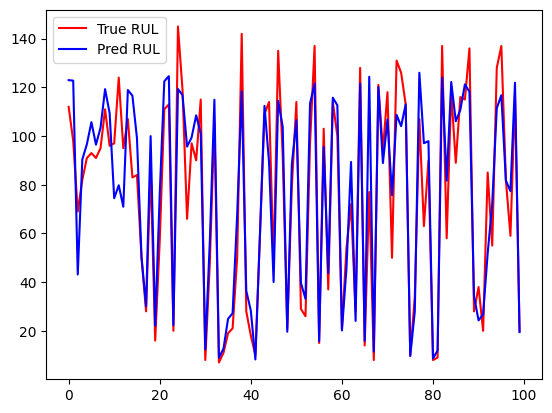

In [150]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()